# Let's use weather data to visualize average temperatures in Northern Europe

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import requests
import dask 
import numpy as np
import pandas as pd


In [4]:
# Lähteenä data CRU TS 4.05 -datasetistä
url = "https://crudata.uea.ac.uk/cru/data/temperature/absolute_v5.nc"

# Tarkistetaan, onko tiedosto jo ladattu
if os.path.exists('absolute_v5.nc'):
    print("Using existing absolute_v5.nc as source.")
else:
    # Lataa tiedosto ja tallenna se
    response = requests.get(url)
    file_Path = 'absolute_v5.nc'

    if response.status_code == 200:
        with open(file_Path, 'wb') as file:
            file.write(response.content)
        print('File downloaded successfully')
    else:
        print('Failed to download file')

ds = xr.open_dataset('absolute_v5.nc', chunks={'time': 10})

# Tulostetaan datasetin sisältö tarkastelua varten
print(ds)

Using existing absolute_v5.nc as source.
<xarray.Dataset> Size: 249kB
Dimensions:  (time: 12, lon: 72, lat: 36)
Coordinates:
  * time     (time) float64 96B 0.5 1.5 2.5 3.5 4.5 ... 7.5 8.5 9.5 10.5 11.5
  * lon      (lon) float32 288B -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * lat      (lat) float32 144B -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
Data variables:
    tem      (time, lat, lon) float64 249kB dask.array<chunksize=(10, 36, 72), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version ?? (http://mpim...
    Conventions:               CF-1.6
    history:                   Wed May 20 16:30:15 2020: ncap2 -O -s time=tim...
    CDO:                       Climate Data Operators version 1.9.3 (http://m...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1
    reference:                 Osborn TJ, Jones PD, Lister DH, Morice CP, Sim...
    licence:                   Open Government Licence http://www.nationalarc...


In [5]:
# Valitaan Pohjois-Euroopan alue (lat: 50-75, lon: -10-40)
ds_north_europe = ds.sel(lat=slice(50, 75), lon=slice(-10, 40))

# Lasketaan aikakeskiarvo lämpötilasta (tem)
mean_temp = ds_north_europe['tem'].mean(dim='time')

# Tulostetaan tarkistettavaksi
print(mean_temp)

<xarray.DataArray 'tem' (lat: 5, lon: 10)> Size: 400B
dask.array<mean_agg-aggregate, shape=(5, 10), dtype=float64, chunksize=(5, 10), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 40B -7.5 -2.5 2.5 7.5 12.5 17.5 22.5 27.5 32.5 37.5
  * lat      (lat) float32 20B 52.5 57.5 62.5 67.5 72.5


In [6]:
# Valitaan Helsinkiä lähinnä oleva datapiste, päädytään lähemmäs Tamperetta
tampere_temp = ds['tem'].sel(lat=60.17, lon=24.94, method='nearest')

# Muutetaan xarray pandas-DataFrameksi
tampere_df = tampere_temp.to_dataframe()

# Tulostetaan kuukausittaiset keskiarvot
print(tampere_df)

# Lasketaan yksinkertainen tilasto: lämpötilan keskiarvo ja -hajonta
mean_temp_tampere = tampere_df['tem'].mean()
std_temp_tampere = tampere_df['tem'].std()
print(f"Tampereen keskilämpötila: {mean_temp_tampere:.2f} °C")
print(f"Tampereen lämpötilan keskihajonta: {std_temp_tampere:.2f} °C")

       lon   lat   tem
time                  
0.5   22.5  62.5  -8.1
1.5   22.5  62.5  -7.8
2.5   22.5  62.5  -3.6
3.5   22.5  62.5   1.9
4.5   22.5  62.5   8.2
5.5   22.5  62.5  13.4
6.5   22.5  62.5  15.6
7.5   22.5  62.5  14.2
8.5   22.5  62.5   9.5
9.5   22.5  62.5   4.6
10.5  22.5  62.5  -0.9
11.5  22.5  62.5  -5.4
Tampereen keskilämpötila: 3.47 °C
Tampereen lämpötilan keskihajonta: 8.70 °C


Mean temperature data:
<xarray.DataArray 'tem' (lat: 5, lon: 10)> Size: 400B
dask.array<mean_agg-aggregate, shape=(5, 10), dtype=float64, chunksize=(5, 10), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 40B -7.5 -2.5 2.5 7.5 12.5 17.5 22.5 27.5 32.5 37.5
  * lat      (lat) float32 20B 52.5 57.5 62.5 67.5 72.5


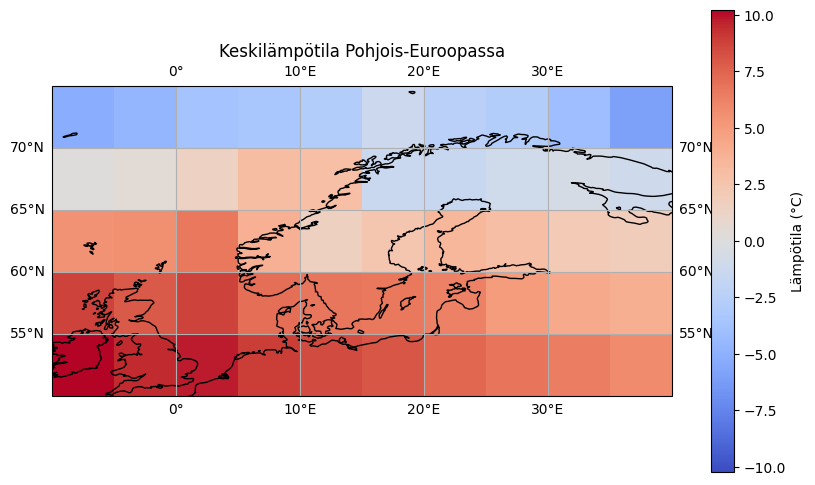

In [8]:

# Varmistetaan tarvittaessa, että mean_temp on laskettu (Dask-laskenta suoritetaan)
# mean_temp = mean_temp.compute()

# Tarkistetaan, että datassa on numeerisia arvoja
print("Mean temperature data:")
print(mean_temp)

# Piirretään kartta Pohjois-Euroopan alueen keskilämpötilasta
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Piirretään lämpötiladata kartalle
mean_temp.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm', cbar_kwargs={'label': 'Lämpötila (°C)'})

# Lisätään kartalle rannikot sekä pituus- ja leveysasteiden rajat)
ax.coastlines()
ax.gridlines(draw_labels=True)

# Asetetaan otsikko
plt.title('Keskilämpötila Pohjois-Euroopassa')
plt.show()

In [9]:
# Tallennetaan käsitelty data Zarr-muotoon
ds_north_europe.to_zarr("north_europe_temperature.zarr")

C:\Users\PC\PycharmProjects\visualisaatiot\.venv\Lib\site-packages\zarr\api\asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Mitä seuraavaksi?
- Samankaltaisen visualisoinnin voisi tehdä myös sademäärästä tai muista sääilmiöistä.
- Vastaavalla tavalla voisimme käsitellä Zarr- tai GRIB2-formaatteja (esim. cfgrib-kirjaston avulla GRIB2-tiedostoille
- Projektissa voisimme käyttää esimerkiksi CDS APIa (Copernicus Climate Data Store) tai NOAA:n APIa saadaksemme reaaliaikaista dataa.
Voit myös kokeilla eri aikavälejä tai muita alueita. Voit myös kokeilla eri visualisointityylejä tai lisätä kartalle muita tietoja, kuten kaupunkeja tai muita maantieteellisiä kohteita.